# About the notebook
This notebook is designed to train a deep learning UNET architecture for segmenting and detecting structures in a 2D input image. The [UNET architecture](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) is a popular choice for image segmentation tasks and it is composed of an encoder path, which extracts high-level features, and a decoder path, which takes the features extracted by the encoder path and generates.

The notebook is intended to be user-friendly, intuitive and does not require any programming skills to train the model. The user only needs to provide a training set consisting of input images and their corresponding target masks (also called ground truth images). The input images represent the images that will be segmented, while the target images contain the desired segmentation mask for each input image.

**Training dataset requirements:** To use the notebook, the user needs to provide the paths of the folders containing the input and target images. These folders should be organized in such a way that each input image has a corresponding target image with the same file name. For example, if the input image is named "image_001.tif", then the corresponding target image should be named "image_001_target.tif". **Please note that the current version of the notebook only accepts images in the TIF file format**. 
<br> *The input image* is required to be in a specific shape, which is \[C1,H,W\], where C1 is the number of channels, and H and W are the height and width of the image, respectively. This means that if the input image contains multiple channels, such as a RGB image, the channels should be included in a single file in the specified shape. 
<br> *The target image* should have the shape \[C2,H,W\], where C2 corresponds to the different objects to be segmented. The target image should be a binary image, where each object to be segmented is represented by a separate binary mask. The value of 1 in the mask corresponds to the object to be detected, and 0 corresponds to the background. It is important to note that the number of channels in the input image and the number of objects to segment in the target image may vary depending on the specific task and the dataset being used.

Once the model is trained, the notebook "Predict_Using_Model.ipynb" can be used to generate segmentation masks for new input images. This can be done by providing a new set of input images and running the trained model on these images.

# 01 - Loading dependencies
In this notebook, before running any code, there are several libraries and modules that need to be imported to ensure that the notebook runs smoothly. These libraries and modules contain pre-written code that performs specific tasks, such as reading and processing images, defining the UNET model, and training the model.

In [2]:
import os
if 'workbookDir' not in globals():
    print('Updating working directory')
    workbookDir = os.path.dirname(os.getcwd())
    os.chdir(workbookDir)
print(os.getcwd())

import numpy as np
from core_code.util import display_images_from_Dataset
from core_code.UNet_2D.Dataset import CustomImageDataset
from core_code.UNet_2D.UNet2d_model import Classic_U_Net_2D
from core_code.train import train_model
from core_code.parameters_interface.parameters_widget import parameters_model_training, parameters_training_images, parameters_device, parameters_data_augmentation
from torch.utils.data import DataLoader
from torch import optim

%load_ext autoreload
%autoreload 2

Updating working directory
C:\Users\jalip\Documentos\github\unet_pytorch_2d


# 02 - Setting required paths of training set
In this section, the user can specify the paths to the training set by specification the folders containing the input images and their corresponding target masks. This is done by setting two parameters: the "Folder path input images" and the "Folder path target mask".

## Required parameters
**Folder path input images**: the path of the folder containing the input images for the training set.

**Folder path target mask**: the path of the folder containing the corresponding target masks for the input images.

In [43]:
parameters_training_set = parameters_training_images()

------------------------------
REQUIRED PARAMETERS
------------------------------


Text(value='', description='Folder path input images:', layout=Layout(flex='1 1 auto', width='auto'), placehol…

Text(value='', description='Folder path target mask:', layout=Layout(flex='1 1 auto', width='auto'), placehold…

# 03 - Visualizing samples from training set
This section is designed to help the user gain a better understanding of the input and target images in the training set. By visualizing these samples, the user can confirm that the images are properly paired and that the target masks accurately represent the structures to be detected in the input images.

In [36]:
training_dataset = CustomImageDataset(parameters_training_set.get()["folder_input"], parameters_training_set.get()["folder_target"])
print('Number of samples in training set: ' + str(len(training_dataset)))
display_images_from_Dataset(training_dataset)

Number of samples in training set: 0


IndexError: list index out of range

# 04 - Data augmentation
Data augmentation is a technique commonly used in machine learning to increase the size and variability of a training set by applying various transformations to the original data. These transformations may include flips, rotations, zooms, and shears, among others. The goal of data augmentation is to provide the model with additional training data that captures different variations of the same object, thereby improving the model's ability to generalize to new datasets.

In cases where the training set is relatively small or contains limited variations, data augmentation can be especially useful. By increasing the variability of the training set, data augmentation helps to prevent the model from overfitting to the limited training data and producing inaccurate results on new datasets.

In this notebook, users have the option to enable or disable data augmentation by selecting the appropriate flag. When disabled, the original training images are used without any transformations.

In [14]:
parameters_augmentation = parameters_data_augmentation()

## Visualizing samples of augmented images
After enabling data augmentation in the notebook, users may want to visualize how the transformed images look like. The "Display sample of augmented images" section provides users with an option to visualize the augmented images in order to assess the effectiveness of the data augmentation process. By visualizing these images, users can determine if the data augmentation process is appropriate and if it is achieving the desired variability in the training set.


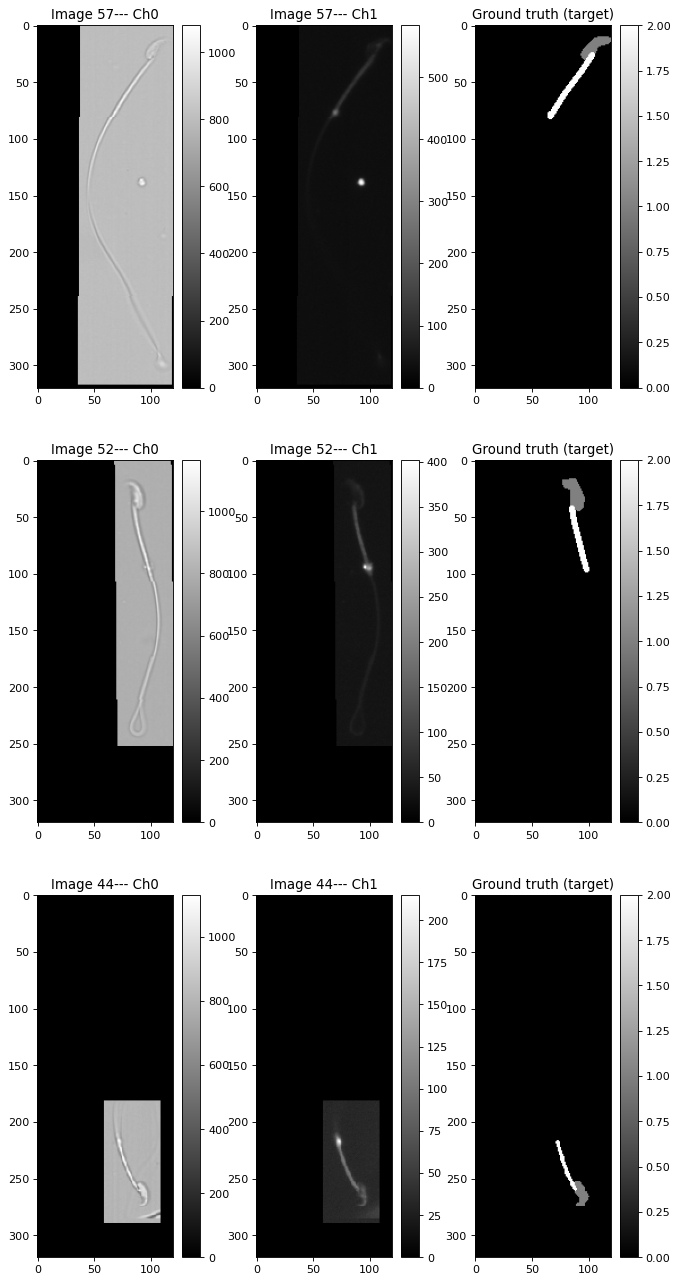

In [15]:
if parameters_augmentation.get()["data_augmentation_flag"]:
    training_dataset.set_data_augmentation(parameters_augmentation.get()["data_augmentation_flag"], parameters_augmentation.get()["data_augmentation_object"])
    display_images_from_Dataset(training_dataset)
else:
    print('Data augmentation disable')
        

# 05 - Constructing the U-Net model
To create the U-Net model, the deep learning practitioner needs to define the architecture of the network, which involves specifying the layers and their connections. In this section, we construct the U-Net model

## Select the device CPU or GPU (if available)
The fact that the U-Net model consists of millions of parameters means that the optimization process can be computationally expensive and time-consuming. However, with the advent of specialized hardware, such as GPUs and TPUs, deep learning practitioners can accelerate the optimization process and train large models like U-Net in a reasonable amount of time. 

In [9]:
p_device = parameters_device()

Dropdown(description='Device: ', options=(('NVIDIA GeForce GTX 1650', 'cuda:0'), ('CPU', 'cpu')), value='cuda:…

## Construct the model in device


In [26]:
# setting data_augmentation in case it is required
training_dataset.set_data_augmentation(parameters_augmentation.get()["data_augmentation_flag"], parameters_augmentation.get()["data_augmentation_object"])

img, target  = training_dataset.__getitem__(0)
n_channels_input  = img.shape[0]
n_channels_target = target.shape[0] 
model = Classic_U_Net_2D(n_channels_input, n_channels_target)
model.to(device= p_device.get_device())
print('------------------------------')
print('------------------------------')
print('Creating a U-Net model. It receives images with ' + str(n_channels_input) + ' channels and predicts an image with ' + str(n_channels_target) + ' channels')
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('The U-Net model have ' + "{:,}".format(trainable_params) + ' parameters to optimize.')
print('------------------------------')
print('------------------------------')

------------------------------
------------------------------
Creating a U-Net model. It receives images with 2 channels and predicts an image with 2 channels
The U-Net model have 31,043,010 parameters to optimize.
------------------------------
------------------------------


# 06 - Train the model
The U-Net model consists of millions of parameters that need to be optimized to achieve accurate segmentation results.
During the training process, the model learns to optimize its parameters to minimize a loss function, which measures the difference between the predicted segmentation and the ground truth segmentation. The optimization process requires defining several important parameters, including: 
<br>**batch size:** the number of images to be use per iteration to compute the gradient.  It is often recommended to use the largest batch size possible that can fit in the available memory without causing an out-of-memory error.
<br>**number of epochs:**  This parameter specifies the number of times the entire dataset is processed during the training process. Setting an appropriate number of epochs  is important to ensure that the model converges to an optimal solution
<br>**validation:** This parameter specifies a separate dataset that is used to evaluate the performance of the model during the training process. The validation dataset is typically used to monitor the progress of the model.
<br>**loss function:** This parameter specifies the function used to measure the difference between the predicted outputs and the ground truth labels.
<br>**optimizer:** This parameter specifies the optimization algorithm used to update the model parameters during training. 


## Setting parameters required to train the model
You can set all the previously describe parameters using the following interface.

In [42]:
parameters_model = parameters_model_training(model, training_dataset, n_channels_target = n_channels_target)

------------------------------
OPTIONAL PARAMETERS
------------------------------


------------------------------


IntText(value=8, description='Batch size: ', layout=Layout(flex='1 1 auto', width='auto'), style=DescriptionSt…

IntText(value=100, description='Number of epochs: ', layout=Layout(flex='1 1 auto', width='auto'), style=Descr…

------------------------------


Dropdown(description='Validation: ', options=(('None', 'None'), ('Folder paths', 'folder_path'), ('% of traini…

VBox()

------------------------------


Dropdown(description='Loss function: ', options=(('Cross entropy loss', 'cross_entropy'), ('Dice loss', 'dice_…

------------------------------


Dropdown(description='Optimizer: ', options=(('Adam', 'Adam'), ('Nesterov_Adam', 'Nesterov_Adam'), ('Stochasti…

------------------------------


## Run training algorithm
This function is the main routine for optimizing the parameters of the U-Net model, using the hyperparameters that are specified by the user

In [18]:
# getting train dataset and validation dataset according to parameters
train_dataset = parameters_model.get("train_dataset")
validation_dataset = parameters_model.get("validation_dataset")

#creating data loaders
train_dataloader = DataLoader(train_dataset, batch_size = parameters_model.get("batch"), shuffle=True, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size = parameters_model.get("batch"))

#getting the criterion to be use to measure the performance of the model to predict target data
loss_function = parameters_model.get("loss_function")

# getting the optimizer to update weight
optimizer = parameters_model.get("optimizer")

# getting device to perform operations (recommended to use GPU)
device = p_device.get_device()

# number of iterations for each image in the training set
epochs = parameters_model.get("epochs")

train = train_model(model = model,
                    train_dataloader = train_dataloader,
                    validation_dataloader = validation_dataloader,
                    list_loss_function = loss_function,
                    optimizer = optimizer,
                    epochs = epochs,
                    device = device
                   )
model = train.run()

Running training
Running iteration 0/80
0.19369306663672128
Running iteration 1/80
0.19151048362255096
Running iteration 2/80
0.1908222275475661
Running iteration 3/80
0.19050422683358192
Running iteration 4/80
0.19006963695089021
Running iteration 5/80
0.18959496480723223
Running iteration 6/80
0.18956116028130054
Running iteration 7/80
0.18902999659379324
Running iteration 8/80
0.18864978849887848
Running iteration 9/80
0.18832258259256682
Running iteration 10/80
0.18786713853478432
Running iteration 11/80
0.1872820177425941
Running iteration 12/80
0.18724358019729456
Running iteration 13/80
0.18660839584966502
Running iteration 14/80
0.18571438640356064
Running iteration 15/80
0.18573925209542116
Running iteration 16/80
0.1850779348363479
Running iteration 17/80
0.18452527498205504
Running iteration 18/80
0.18340508018930754
Running iteration 19/80
0.18289116707940897
Running iteration 20/80
0.18240059663852057
Running iteration 21/80
0.18130520979563394
Running iteration 22/80
0.18

In [20]:
import core_code.util as util
import torch

In [21]:
model.eval()
img_test = util.imread(r'C:\Users\jalip\Documentos\Proyectos\Victor_LNMA\AMNIS\training_set_Final\input\13_ch.ome.tif')
with torch.no_grad():
    img_test = torch.tensor(img_test, dtype = torch.float32)
    img_test = img_test[None]
    output = model(img_test).cpu()
    mask = torch.sigmoid(output) > 0.5
    mask = output 
    mask = torch.sigmoid(output)
    mask = mask.squeeze().numpy()
    util.imwrite(r'C:\Users\jalip\Documentos\Proyectos\Victor_LNMA\AMNIS\13_ch.ome_model.tif', 255*mask)
    